In [ ]:
!git clone https://github.com/insilicomedicine/GENTRL.git

fatal: destination path 'GENTRL' already exists and is not an empty directory.


In [1]:
!pip install rdkit-pypi -qqq

     |████████████████████████████████| 22.5 MB 2.2 MB/s 


In [ ]:
!git clone https://github.com/molecularsets/moses.git

fatal: destination path 'moses' already exists and is not an empty directory.


In [ ]:
!cp -r /content/moses/moses /content/GENTRL

In [ ]:
!git clone https://github.com/insilicomedicine/fcd_torch.git

fatal: destination path 'fcd_torch' already exists and is not an empty directory.


In [ ]:
!cp -r fcd_torch/fcd_torch/ /content/GENTRL

In [ ]:
%cd /content/GENTRL

/content/GENTRL


In [ ]:
%cd /content/drive/MyDrive/Biopharma/GENTRL

/content/drive/MyDrive/Biopharma/GENTRL


In [3]:
%cd /content/drive/MyDrive/Biopharma/GENTRL

/content/drive/MyDrive/Biopharma/GENTRL


In [4]:
import gentrl
import torch
from rdkit.Chem import Draw
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
import pandas as pd

In [5]:
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
import pandas as pd

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=False, default=-5):
  try:
    mol = get_mol(mol_or_smiles)
    print("called")
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward
  except :
    print(mol_or_smiles)
    #print(Chem.MolFromSmiles(mol_or_smiles))
    pass

In [6]:
df1 = pd.read_csv("HBB_Activities.csv", delimiter =';', usecols=['Smiles'])
df1.head()

,Smiles
0,CN1CC=C2C(C#N)=C(N)C(C#N)(C#N)C(c3cccc(Cl)c3Cl...
1,COc1cccc(Nc2ncc3nc(-c4ccc(Cl)cc4)c(=O)n(CCC#N)...
2,CNC(=O)c1c(NC(=O)c2nc3ccccc3s2)sc2c1CCC2
3,Cc1n[nH]c(C)c1N1C(=O)c2cccc3c(N4CCCCCC4)ccc(c2...
4,Cc1cc(NC(=O)COC(=O)COc2cccc3c2OC(C)(C)C3)no1


In [7]:
train = int(0.8*len(df1))
df1["SPLIT"] = ""
for index, row in df1.iterrows():
  if index <train:
    df1.at[index, "SPLIT"] = 'train'
  else:
    df1.at[index, "SPLIT"] = 'test'

df1.tail()


,Smiles,SPLIT
1460,COc1ccc(OCc2ccccn2)c(C=O)c1,test
1461,O=C(/C=C/c1ncc[nH]1)c1ccccc1,test
1462,O=c1[nH]cc(F)c(=O)[nH]1,test
1463,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C...,test
1464,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,test


In [8]:
df1.rename(columns={'Smiles':"SMILES"}, inplace = True)

In [9]:
df1['plogP'] = df1['SMILES'].apply(penalized_logP)
df1 = df1.dropna()
df1.to_csv('train_plogp_plogpm.csv', index=None)
temp = pd.read_csv("train_plogp_plogpm.csv")
temp.head()

called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
nan
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
called
ca

,SMILES,SPLIT,plogP
0,CN1CC=C2C(C#N)=C(N)C(C#N)(C#N)C(c3cccc(Cl)c3Cl...,train,-0.535200
1,COc1cccc(Nc2ncc3nc(-c4ccc(Cl)cc4)c(=O)n(CCC#N)...,train,1.694904
2,CNC(=O)c1c(NC(=O)c2nc3ccccc3s2)sc2c1CCC2,train,1.136865
3,Cc1n[nH]c(C)c1N1C(=O)c2cccc3c(N4CCCCCC4)ccc(c2...,train,0.804118
4,Cc1cc(NC(=O)COC(=O)COc2cccc3c2OC(C)(C)C3)no1,train,-0.199416


In [11]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
#model.cuda();

md = gentrl.MolecularDataset(sources=[
    {'path':'train_plogp_plogpm.csv',
     'smiles': 'SMILES',
     'prob': 1,
     'plogP' : 'plogP',
    }], 
    props=['plogP'])

from torch.utils.data import DataLoader
train_loader = DataLoader(md, batch_size=50, shuffle=True, num_workers=1, drop_last=True)

In [ ]:
from importlib import reload 	
reload(gentrl)

%load_ext autoreload
%autoreload 2
model.train_as_vaelp(train_loader, lr=1e-4,)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 0 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch 2 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch 4 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch 6 :
!!!!!!!!!!!!!!!

/content/drive/MyDrive/Biopharma/GENTRL/gentrl/lp.py:108: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  x[missed] = 0
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


!!!!!!!!!!!!!!loss: 2.184;rec: -2.05;kl: -57.17;log_p_y_by_z: -1.912;log_p_z_by_y: -67.95;
Epoch 8 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.897;rec: -1.766;kl: -50.56;log_p_y_by_z: -1.814;log_p_z_by_y: -59.34;


In [ ]:
! mkdir -p saved_gentrl2

In [ ]:
model.save('./saved_gentrl4/')

In [ ]:
pwd

'/content/drive/MyDrive/Biopharma/GENTRL'

In [ ]:
model.load('saved_gentrl4/')
model.cuda();

FileNotFoundError: ignored

In [13]:
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol

from moses.utils import disable_rdkit_log
disable_rdkit_log()

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [16]:
model.train_as_rl(penalized_logP, num_iterations=5050)

!

/content/drive/MyDrive/Biopharma/GENTRL/gentrl/lp.py:108: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  x[missed] = 0


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.621;valid_perc: 0.23;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.61;valid_perc: 0.2297;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.503;valid_perc: 0.2378;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.403;valid_perc: 0.2444;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.375;valid_perc: 0.2438;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.264;valid_perc: 0.2552;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.212;valid_perc: 0.2511;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.08;valid_perc: 0.2612;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.06;valid_perc: 0.2609;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -2.923;valid_perc: 0.2723;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -2.809;valid_perc: 0.2754;
!!!!!!!!!!!!!!!!!

In [17]:
! mkdir -p saved_gentrl_after_rl6

In [18]:
model.save('./saved_gentrl_after_rl6/')

In [15]:
model.load('saved_gentrl_after_rl4/')
model.cuda()

GENTRL(
  (enc): RNNEncoder(
    (embs): Embedding(42, 256)
    (rnn): GRU(256, 256, num_layers=2)
    (final_mlp): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=100, bias=True)
    )
  )
  (dec): DilConvDecoder(
    (latent_fc): Linear(in_features=50, out_features=128, bias=True)
    (input_embeddings): Embedding(42, 128)
    (logits_1x1_layer): Conv1d(128, 42, kernel_size=(1,), stride=(1,))
    (parameters): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 42x128 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 42x128x1 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 42 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 128x50 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
        (5): Parameter containing: [torch

In [19]:
generated = []

while len(generated) <= 1000:
    
    sampled = model.sample(100)
    print("Generate a molecule", len(generated))
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated += sampled_valid

/content/drive/MyDrive/Biopharma/GENTRL/gentrl/lp.py:108: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  x[missed] = 0


Generate a molecule 0
Generate a molecule 83
Generate a molecule 170
Generate a molecule 250
Generate a molecule 330
Generate a molecule 411
Generate a molecule 493
Generate a molecule 577
Generate a molecule 654
Generate a molecule 733
Generate a molecule 813
Generate a molecule 891
Generate a molecule 973


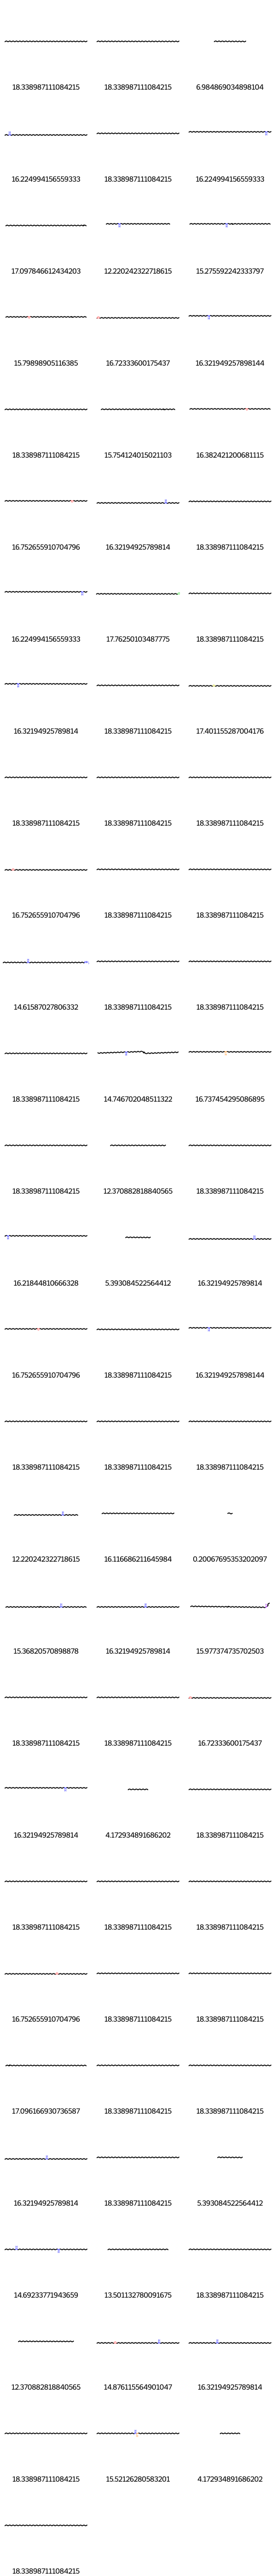

In [20]:
Draw.MolsToGridImage([get_mol(s) for s in sampled_valid], 
                     legends=[str(penalized_logP(s)) for s in sampled_valid])

In [ ]:
!cp -r /content/GENTRL /content/drive/MyDrive/Biopharma/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
